# Reinforcement Learning 2025 - Policy Evaluation

**Authors:** Gal Yaacov Noy, Amit Ezer.

**Goal:** Comprehensive evaluation of all trained SARSA and Double Q-Learning policies across different configurations and environments.

This notebook provides a reproducible evaluation procedure that runs each trained policy for 100 episodes and reports detailed performance metrics with visualizations and summary statistics.

In [124]:
!pip install minigrid gymnasium matplotlib

In [125]:
import os
import numpy as np
import gymnasium as gym
import minigrid
import matplotlib.pyplot as plt
import pickle
from IPython.display import Video, display

np.random.seed(42)

In [126]:
def get_discrete_state(env):
    """
    Discretize the state: (flat_position, direction, is_blocked).
    `env` must be the unwrapped MiniGrid environment.
    """
    x = (env.agent_pos[0] - 1) * (env.width - 2) + (env.agent_pos[1] - 1)  # Flatten the position
    direction = env.agent_dir

    # Check if the front cell is blocked
    front_cell = env.grid.get(*env.front_pos)
    if front_cell is None:
        blocked = 0
    else:
        blocked = int(front_cell.type != "goal")

    return (x, direction, blocked)

def get_shaped_reward(obs, reward, use_shaping):
    """Shape reward: bonus for facing goal (ID 8), penalty for obstacle."""
    if not use_shaping:
        return reward

    img = obs["image"][:, :, 0]
    center = np.array(img.shape) // 2
    dx, dy = {
        0: (-1, 0),   # Up
        1: (0, 1),    # Right
        2: (1, 0),    # Down
        3: (0, -1),   # Left
    }[obs["direction"]]

    fx, fy = center[0] + dx, center[1] + dy
    if not (0 <= fx < img.shape[0] and 0 <= fy < img.shape[1]):
        return reward  # Facing out of bounds

    tile = img[fx, fy]
    if tile == 8:
        return reward + 0.2  # Facing goal
    elif tile != 0:
        return reward - 0.1  # Facing obstacle

    return reward

In [ ]:
def run_episode(env, q_func, max_steps=200):
    """Run a single episode using the provided Q-function."""
    obs, _ = env.reset()
    base_env = env.unwrapped
    total_reward, step = 0, 0
    terminated = truncated = False

    while not (terminated or truncated) and step < max_steps:
        # Get discrete state using the same function as training
        x, d, b = get_discrete_state(base_env)
        
        # Greedily select action
        q_values = q_func((x, d, b))
        action = np.argmax(q_values)
        
        next_obs, reward, terminated, truncated, _ = env.step(action)
        
        # Apply reward shaping (same as training)
        shaped_reward = get_shaped_reward(next_obs, reward, use_shaping=True)
        
        total_reward += shaped_reward
        step += 1

    return total_reward, step, shaped_reward > 0 and terminated

In [128]:
def load_policy(policy_path):
    """Load a Q-table policy from pickle file."""
    with open(policy_path, "rb") as f:
        return pickle.load(f)

def evaluate_policy(env, q_func, num_episodes=100, max_steps=200):
    """Evaluate a deterministic policy over multiple episodes using Q-table directly."""
    rewards, steps, successes = [], [], []
        
    for episode in range(num_episodes):
        total_reward, step, success = run_episode(env, q_func, max_steps)
        rewards.append(total_reward)
        steps.append(step)
        successes.append(success)
        
        if episode % 20 == 0:
            print(f"  Episode {episode}: Reward={total_reward:.2f}, Steps={step}, Success={success}")

    return {
        "rewards": rewards,
        "steps": steps,
        "successes": successes,
    }

In [129]:
def record_final_video(q_func, env="6x6", model="sarsa"):
    """Record a video of a single greedy policy episode."""
    
    env_name = f"MiniGrid-Dynamic-Obstacles-{env}-v0"
    filename = f"{env}-{model}-final"
    video_dir = "videos"
    
    os.makedirs(video_dir, exist_ok=True)

    env_wrapped = RecordVideo(
        gym.make(env_name, render_mode="rgb_array"),
        video_folder=video_dir,
        name_prefix=filename,
        episode_trigger=lambda _: True
    )

    run_episode(env_wrapped, q_func, max_steps=100)
    env_wrapped.close()
    
    return os.path.join(video_dir, f"{filename}-episode-0.mp4")

In [130]:
def run_evaluation(config_name, env_name, policies_folder):
    """Run evaluation for a configuration and return results with videos."""
    print(f"\n{'='*50}")
    print(f"EVALUATING: {config_name}")
    print(f"{'='*50}")
    
    env = gym.make(env_name)
    env_size = "6x6" if "6x6" in env_name else "8x8"
    results = {}
    
    # Load and evaluate SARSA
    sarsa_q = load_policy(f"policies/{policies_folder}/sarsa_q.pkl")
    sarsa_q_func = lambda s: sarsa_q[s]
    print("Evaluating SARSA...")
    results["SARSA"] = evaluate_policy(env, sarsa_q_func)
    results["SARSA"]["video"] = record_final_video(sarsa_q_func, env_size, "sarsa")
    
    # Load and evaluate Double Q-Learning
    dq_q1 = load_policy(f"policies/{policies_folder}/double_q1.pkl")
    dq_q2 = load_policy(f"policies/{policies_folder}/double_q2.pkl")
    dq_q_func = lambda s: dq_q1[s] + dq_q2[s]
    print("Evaluating Double Q-Learning...")
    results["Double Q-Learning"] = evaluate_policy(env, dq_q_func)
    results["Double Q-Learning"]["video"] = record_final_video(dq_q_func, env_size, "double_q")
    
    env.close()
    return results

In [131]:
# Run evaluations for best 6x6 and 8x8 configurations only
configs = [
    ("6x6", "MiniGrid-Dynamic-Obstacles-6x6-v0", "random_q_init_+_reward_shaping"),
    ("8x8", "MiniGrid-Dynamic-Obstacles-8x8-v0", "8x8_dynamic_obstacles")
]

all_results = {}
for config_name, env_name, folder in configs:
    all_results[config_name] = run_evaluation(config_name, env_name, folder)

# Add summary metrics
for config_name, results in all_results.items():
    for alg_name, metrics in results.items():
        metrics["success_rate"] = np.mean(metrics["successes"])
        metrics["avg_reward"] = np.mean(metrics["rewards"])
        metrics["avg_steps"] = np.mean(metrics["steps"])


EVALUATING: 6x6
Evaluating SARSA...
  Episode 0: Reward=0.34, Steps=9, Success=True
  Episode 20: Reward=0.56, Steps=7, Success=True
  Episode 40: Reward=-1.78, Steps=29, Success=True
  Episode 60: Reward=-1.57, Steps=27, Success=True
  Episode 80: Reward=0.69, Steps=17, Success=True
Evaluating Double Q-Learning...
  Episode 0: Reward=0.50, Steps=16, Success=True
  Episode 20: Reward=0.03, Steps=12, Success=True
  Episode 40: Reward=-0.83, Steps=20, Success=True
  Episode 60: Reward=0.56, Steps=7, Success=True
  Episode 80: Reward=-1.25, Steps=24, Success=True

EVALUATING: 8x8
Evaluating SARSA...
  Episode 0: Reward=-0.15, Steps=14, Success=True
  Episode 20: Reward=-0.15, Steps=14, Success=True
  Episode 40: Reward=-0.05, Steps=13, Success=True
  Episode 60: Reward=0.16, Steps=11, Success=True
  Episode 80: Reward=-0.87, Steps=21, Success=True
Evaluating Double Q-Learning...
  Episode 0: Reward=8.20, Steps=200, Success=False
  Episode 20: Reward=8.50, Steps=200, Success=False
  Episo

In [132]:
# Results summary and video display
print(f"\n{'='*80}")
print("EVALUATION RESULTS SUMMARY")
print(f"{'='*80}")
print(f"{'Configuration':<15} {'Algorithm':<18} {'Success Rate':<12} {'Avg Reward':<12} {'Avg Steps':<10}")
print("-" * 70)

for config_name, results in all_results.items():
    for alg_name, metrics in results.items():
        success_rate = metrics["success_rate"]
        print(f"{config_name:<15} {alg_name:<18} {success_rate:<12.3f} {metrics['avg_reward']:<12.3f} {metrics['avg_steps']:<10.1f}")

# Display videos
print(f"\n{'='*50}")
print("PERFORMANCE VIDEOS")
print(f"{'='*50}")

for config_name, results in all_results.items():
    print(f"\n{config_name} Results:")
    for alg_name, metrics in results.items():
        print(f"\n{alg_name} - Success Rate: {metrics['success_rate']:.3f}")
        display(Video(metrics["video"], width=400, height=300))


EVALUATION RESULTS SUMMARY
Configuration   Algorithm          Success Rate Avg Reward   Avg Steps 
----------------------------------------------------------------------
6x6             SARSA              1.000        -0.056       14.1      
6x6             Double Q-Learning  1.000        0.097        13.1      
8x8             SARSA              0.890        -2.363       35.3      
8x8             Double Q-Learning  0.000        8.137        200.0     

PERFORMANCE VIDEOS

6x6 Results:

SARSA - Success Rate: 1.000



Double Q-Learning - Success Rate: 1.000



8x8 Results:

SARSA - Success Rate: 0.890



Double Q-Learning - Success Rate: 0.000



DETAILED PERFORMANCE ANALYSIS

6x6 Results:
SARSA – Success Rate: 1.000, Avg Reward: -0.056, Avg Steps: 14.1
Double Q-Learning – Success Rate: 1.000, Avg Reward: 0.097, Avg Steps: 13.1


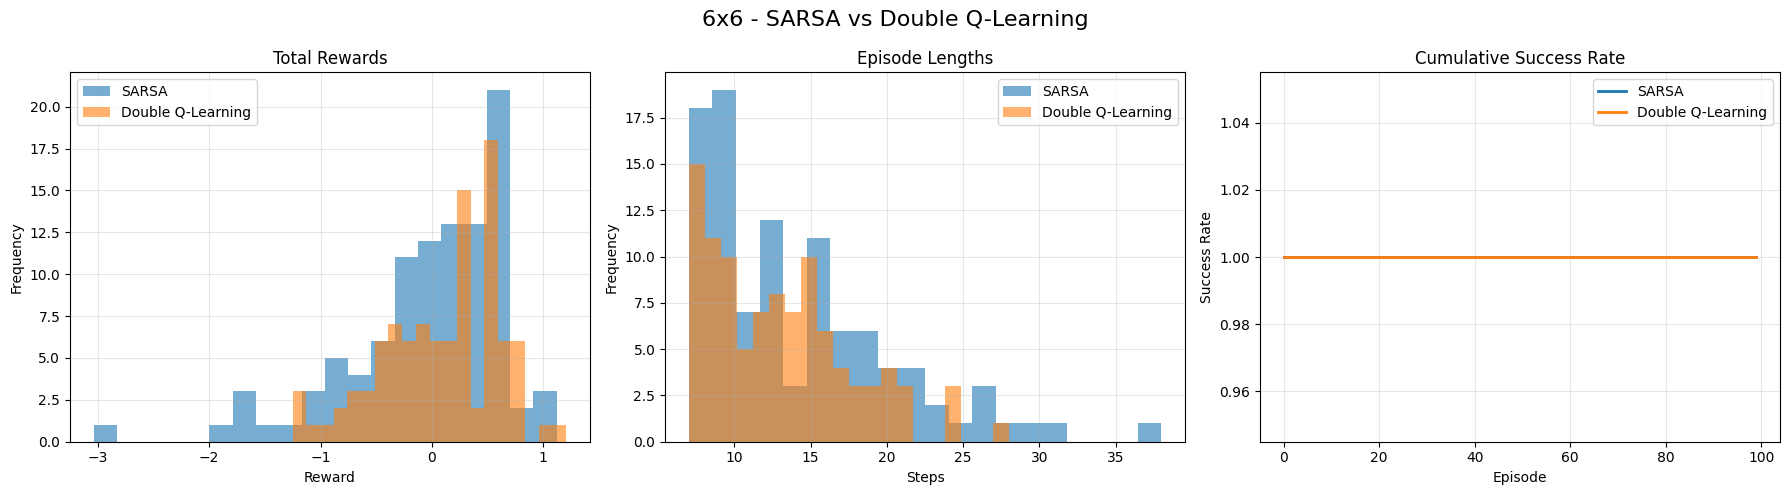


8x8 Results:
SARSA – Success Rate: 0.890, Avg Reward: -2.363, Avg Steps: 35.3
Double Q-Learning – Success Rate: 0.000, Avg Reward: 8.137, Avg Steps: 200.0


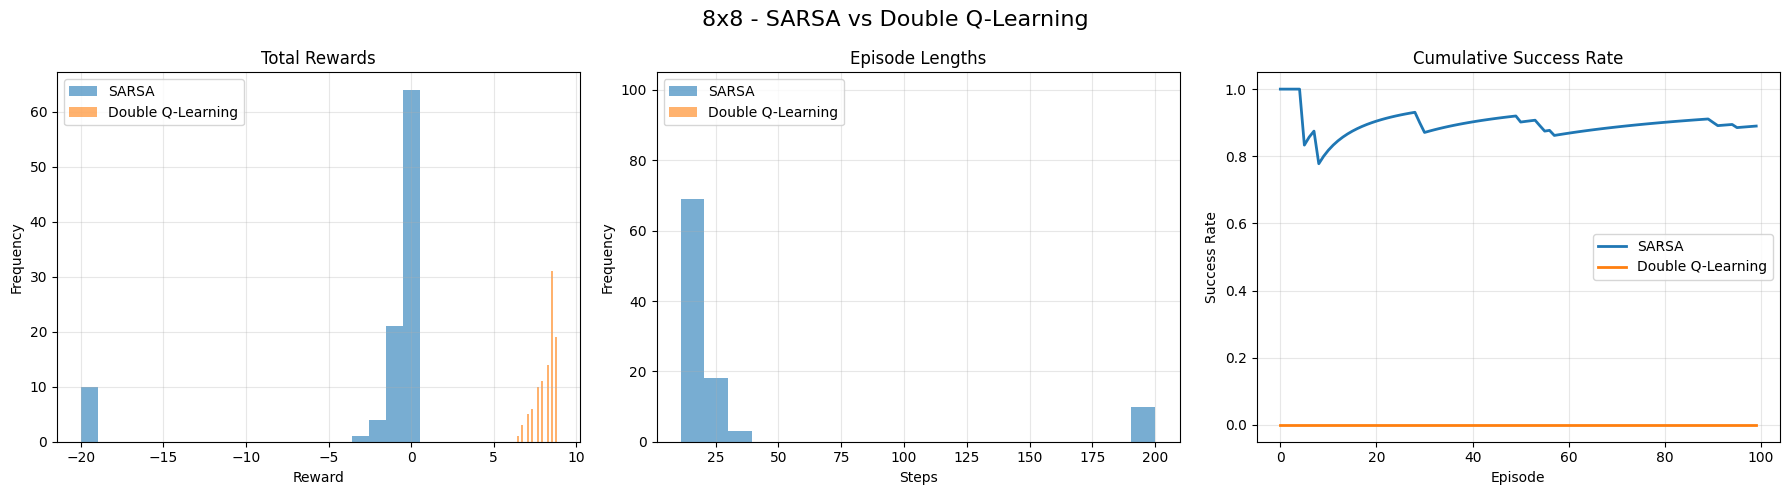


Evaluation complete!


In [133]:
# Comparison plots like evaluation.ipynb
def plot_eval_comparison(results_6x6, results_8x8, title_suffix):
    """Plot comparison between SARSA and Double Q-Learning for a configuration."""
    sarsa_results = results_6x6["SARSA"] if "6x6" in title_suffix else results_8x8["SARSA"]
    dq_results = results_6x6["Double Q-Learning"] if "6x6" in title_suffix else results_8x8["Double Q-Learning"]
    
    print(f"\n{title_suffix} Results:")
    print(f"SARSA – Success Rate: {np.mean(sarsa_results['successes']):.3f}, "
          f"Avg Reward: {np.mean(sarsa_results['rewards']):.3f}, "
          f"Avg Steps: {np.mean(sarsa_results['steps']):.1f}")
    
    print(f"Double Q-Learning – Success Rate: {np.mean(dq_results['successes']):.3f}, "
          f"Avg Reward: {np.mean(dq_results['rewards']):.3f}, "
          f"Avg Steps: {np.mean(dq_results['steps']):.1f}")

    fig, axs = plt.subplots(1, 3, figsize=(18, 5))
    fig.suptitle(f"{title_suffix} - SARSA vs Double Q-Learning", fontsize=16)

    # Histogram of rewards
    axs[0].hist(sarsa_results["rewards"], bins=20, alpha=0.6, label="SARSA")
    axs[0].hist(dq_results["rewards"], bins=20, alpha=0.6, label="Double Q-Learning")
    axs[0].set_title("Total Rewards")
    axs[0].set_xlabel("Reward")
    axs[0].set_ylabel("Frequency")
    axs[0].legend()
    axs[0].grid(alpha=0.3)

    # Histogram of steps
    axs[1].hist(sarsa_results["steps"], bins=20, alpha=0.6, label="SARSA")
    axs[1].hist(dq_results["steps"], bins=20, alpha=0.6, label="Double Q-Learning")
    axs[1].set_title("Episode Lengths")
    axs[1].set_xlabel("Steps")
    axs[1].set_ylabel("Frequency")
    axs[1].legend()
    axs[1].grid(alpha=0.3)

    # Success rate over episodes
    sarsa_sr = np.cumsum(sarsa_results["successes"]) / np.arange(1, len(sarsa_results["successes"]) + 1)
    dq_sr = np.cumsum(dq_results["successes"]) / np.arange(1, len(dq_results["successes"]) + 1)

    axs[2].plot(sarsa_sr, label="SARSA", linewidth=2)
    axs[2].plot(dq_sr, label="Double Q-Learning", linewidth=2)
    axs[2].set_title("Cumulative Success Rate")
    axs[2].set_xlabel("Episode")
    axs[2].set_ylabel("Success Rate")
    axs[2].legend()
    axs[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

print(f"\n{'='*60}")
print("DETAILED PERFORMANCE ANALYSIS")
print(f"{'='*60}")

# Plot comparisons for each environment
plot_eval_comparison(all_results["6x6"], all_results["8x8"], "6x6")
plot_eval_comparison(all_results["6x6"], all_results["8x8"], "8x8")

print("\nEvaluation complete!")